In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


In [3]:
# Connect Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/DATA 6560/Data/Final dataset/merged_data (1).csv")

# Drop outliers identified in CP5 + Countries where the NFL already has games
df = df[~df["Country"].isin(["Papua New Guinea", "United States", "United Kingdom", "Germany", "Spain", "Brazil", "Ireland"])].copy()

# Find rows with any missing values
rows_with_na = df[df.isna().any(axis=1)]

# Define column names explicitly
fan_col = "gt_composite"
stadium_count_col = "stadium_count"
stadium_capacity_col = "average_stadium_capacity"
gdp_col = "gdp_per_capita"
population_col = "population"
urban_col = "urban_pct"
connect_col = "connectivity_index"
country_col = "Country"

# Show unique country names
countries_with_na = rows_with_na[country_col].unique()

print("Countries with missing values:")
print(list(countries_with_na))

# Drop rows with missing values
df = df.dropna().copy()

print("Remaining rows after dropping missing values:", len(df))

df.isna().sum().sum()

Countries with missing values:
['American Samoa', 'Andorra', 'Aruba', 'Belize', 'Bermuda', 'Bhutan', 'British Virgin Islands', 'Cayman Islands', 'Comoros', 'Dominica', 'Eritrea', 'Eswatini', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Guyana', 'Haiti', 'Iceland', 'Isle of Man', 'Kiribati', 'Kosovo', 'Latvia', 'Lebanon', 'Liechtenstein', 'Luxembourg', 'Marshall Islands', 'Mongolia', 'Namibia', 'Nauru', 'New Caledonia', 'Northern Mariana Islands', 'Palau', 'Samoa', 'San Marino', 'Sierra Leone', 'Solomon Islands', 'South Sudan', 'St. Lucia', 'Suriname', 'Switzerland', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu']
Remaining rows after dropping missing values: 128


np.int64(0)

In [5]:
# Inspect columns
print(df.columns)

Index(['ISO2', 'Country', 'gt_NFL', 'gt_American_football', 'gt_Super_Bowl',
       'gt_composite', 'gdp_per_capita', 'population', 'urban_pct',
       'stadium_count', 'total_stadium_capacity', 'average_stadium_capacity',
       'airport_count', 'total_routes', 'unique_dest_countries',
       'hub_strength', 'airport_count_scaled', 'total_routes_scaled',
       'unique_dest_countries_scaled', 'hub_strength_scaled',
       'connectivity_index'],
      dtype='object')


In [8]:
# Normalize raw inputs to 0–1
scaler = MinMaxScaler()

cols_to_scale = [
    fan_col,
    stadium_count_col, stadium_capacity_col,
    gdp_col, population_col, urban_col, connect_col
]

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# ----- Create composite pillars -----

# Infrastructure Readiness (simple average)
df["infrastructure_readiness"] = (
    df[stadium_count_col] * 0.5 +
    df[stadium_capacity_col] * 0.5
)

# Economic Readiness (weighted average)
df["economic_readiness"] = (
    df[gdp_col] * 0.5 +
    df[population_col] * 0.1 +
    df[urban_col] * 0.4
)

In [16]:
# Hierarchical Clustering
features = [
    fan_col,
    "economic_readiness",
    "infrastructure_readiness",
    connect_col
]

X = df[features].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Linkage matrix
Z = linkage(X_scaled, method="ward")

# Choose number of clusters
n_clusters = 4

# Get cluster labels from linkage matrix
labels_hier = fcluster(Z, n_clusters, criterion='maxclust')

# Silhouette score
sil_score_hier = silhouette_score(X_scaled, labels_hier)
print(f"Hierarchical Clustering Silhouette Score: {sil_score_hier:.3f}")


Hierarchical Clustering Silhouette Score: 0.212


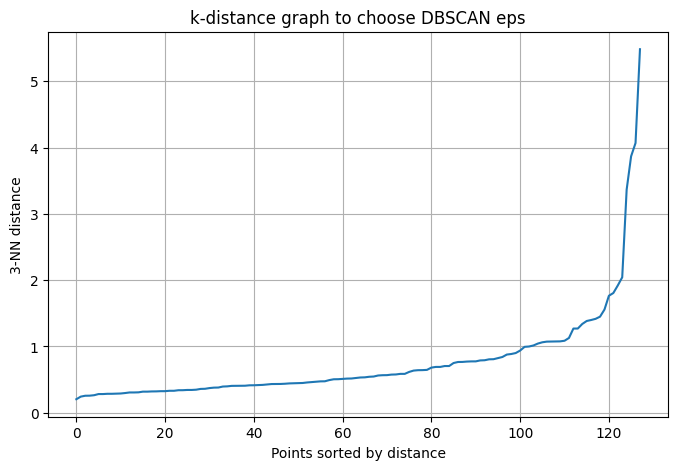

DBSCAN found 1 clusters and 0 noise points.


In [20]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

min_samples = 3  # DBSCAN parameter

# Compute distances to min_samples nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Distance to the k-th nearest neighbor
k_distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN distance")
plt.title("k-distance graph to choose DBSCAN eps")
plt.grid(True)
plt.show()




In [39]:
eps_opt = 0.91
dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples)
labels_db = dbscan.fit_predict(X_scaled)

# Number of clusters and noise points
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = list(labels_db).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")

DBSCAN found 2 clusters and 24 noise points.


In [40]:
# Silhouette score (ignore noise)
mask = labels_db != -1
if n_clusters > 1:
    sil_score = silhouette_score(X_scaled[mask], labels_db[mask])
    print(f"DBSCAN Silhouette Score: {sil_score:.3f}")

DBSCAN Silhouette Score: 0.298


In [55]:
# Add interactions between features
df['econ_fan_interaction'] = df['economic_readiness'] * df[fan_col]
cluster_features = features + ['econ_fan_interaction']

X = df[cluster_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of cluster
n_clusters = 4

# Fit K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Silhouette score
sil_score = silhouette_score(X_scaled, labels_kmeans)
print(f"K-Means Silhouette Score with interaction feature: {sil_score:.3f}")

K-Means Silhouette Score with interaction feature: 0.319


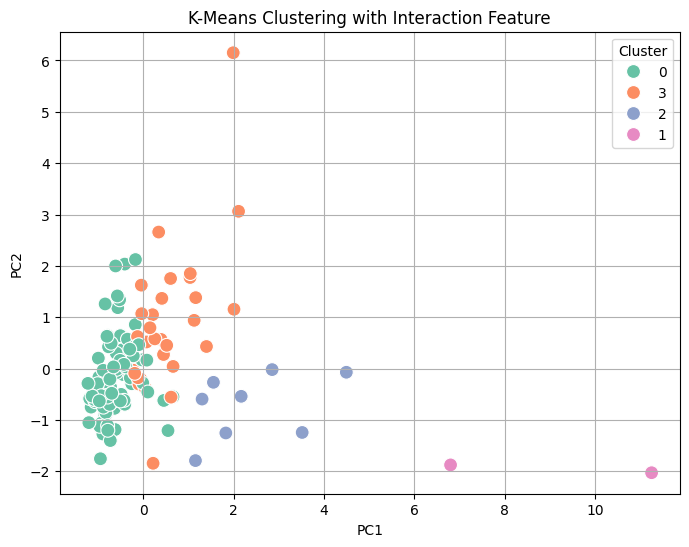

In [56]:
# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Prepare DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca[:,0],
    'PC2': X_pca[:,1],
    'Cluster': labels_kmeans.astype(str)  # convert to string for seaborn
})

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_df, palette='Set2', s=100)
plt.title('K-Means Clustering with Interaction Feature')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

In [ ]:
# MAI weights # 1
w_fan = 0.25
w_econ = 0.25
w_infra = 0.25
w_connect = 0.25

# Create composite index

df["MAI"] = (
    w_fan * df[fan_col] +
    w_econ * df["economic_readiness"] +
    w_infra * df["infrastructure_readiness"] +
    w_connect * df[connect_col]
)

# Rank markets
df["MAI_rank"] = df["MAI"].rank(ascending=False)

# Top 10
top10 = df.sort_values("MAI", ascending=False)[[country_col, "MAI"]].head(10)
print(top10)


                  Country       MAI
30                 Canada  0.595540
35                  China  0.517537
58                 France  0.435222
109                Mexico  0.420938
9               Australia  0.400370
119           Netherlands  0.371630
138                 Qatar  0.363405
173  United Arab Emirates  0.339985
10                Austria  0.339761
149             Singapore  0.333719


In [57]:
# MAI weights # 2
w_fan = 0.4
w_econ = 0.3
w_infra = 0.2
w_connect = 0.1

# Create composite index

df["MAI"] = (
    w_fan * df[fan_col] +
    w_econ * df["economic_readiness"] +
    w_infra * df["infrastructure_readiness"] +
    w_connect * df[connect_col]
)

# Rank markets
df["MAI_rank"] = df["MAI"].rank(ascending=False)

# Top 10
top10 = df.sort_values("MAI", ascending=False)[[country_col, "MAI"]].head(10)
print(top10)

         Country       MAI
30        Canada  0.649607
109       Mexico  0.491385
9      Australia  0.397665
35         China  0.351984
121  New Zealand  0.343417
58        France  0.306632
10       Austria  0.305935
119  Netherlands  0.294409
138        Qatar  0.284986
111       Monaco  0.284546


In [58]:
# MAI weights # 3
w_fan = 0.2
w_econ = 0.4
w_infra = 0.25
w_connect = 0.15

# Create composite index

df["MAI"] = (
    w_fan * df[fan_col] +
    w_econ * df["economic_readiness"] +
    w_infra * df["infrastructure_readiness"] +
    w_connect * df[connect_col]
)

# Rank markets
df["MAI_rank"] = df["MAI"].rank(ascending=False)

# Top 10
top10 = df.sort_values("MAI", ascending=False)[[country_col, "MAI"]].head(10)
print(top10)

         Country       MAI
30        Canada  0.541144
35         China  0.474469
9      Australia  0.410275
109       Mexico  0.407364
58        France  0.399822
138        Qatar  0.385958
111       Monaco  0.378183
119  Netherlands  0.371324
149    Singapore  0.369331
121  New Zealand  0.342660


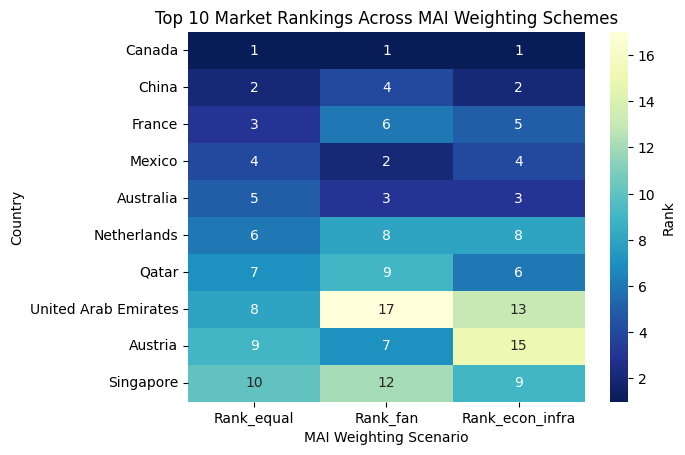

In [64]:
# Equal weights
w_fan = 0.25
w_econ = 0.25
w_infra = 0.25
w_connect = 0.25
df['MAI_equal'] = (
    w_fan * df[fan_col] +
    w_econ * df['economic_readiness'] +
    w_infra * df['infrastructure_readiness'] +
    w_connect * df[connect_col]
)

# Prioritizing fan engagement
w_fan = 0.4
w_econ = 0.3
w_infra = 0.2
w_connect = 0.1
df['MAI_fan'] = (
    w_fan * df[fan_col] +
    w_econ * df['economic_readiness'] +
    w_infra * df['infrastructure_readiness'] +
    w_connect * df[connect_col]
)

# Prioritizing economics/infrastructure
w_fan = 0.2
w_econ = 0.4
w_infra = 0.25
w_connect = 0.15
df['MAI_econ_infra'] = (
    w_fan * df[fan_col] +
    w_econ * df['economic_readiness'] +
    w_infra * df['infrastructure_readiness'] +
    w_connect * df[connect_col]
)

# Create a combined DataFrame
mai_df = pd.DataFrame({
    'Country': df[country_col],
    'MAI_equal': df['MAI_equal'],  # store equal weights MAI in this column
    'MAI_fan': df['MAI_fan'],      # store fan-prioritized MAI
    'MAI_econ_infra': df['MAI_econ_infra']  # store econ/infrastructure-prioritized MAI
})

# Compute ranks for each scenario
mai_df['Rank_equal'] = mai_df['MAI_equal'].rank(ascending=False).astype(int)
mai_df['Rank_fan'] = mai_df['MAI_fan'].rank(ascending=False).astype(int)
mai_df['Rank_econ_infra'] = mai_df['MAI_econ_infra'].rank(ascending=False).astype(int)

# Select top 10 by equal weights for display
top10_mai = mai_df.sort_values('Rank_equal').head(10)
top10_mai
# Prepare data: top 10 by equal weights
top10_heat = top10_mai.set_index('Country')[['Rank_equal', 'Rank_fan', 'Rank_econ_infra']]

# Optional: convert to string so heatmap shows ranks clearly
top10_heat = top10_heat.astype(int)

# Plot heatmap

sns.heatmap(top10_heat, annot=True, fmt='d', cmap='YlGnBu_r', cbar_kws={'label': 'Rank'})

plt.title('Top 10 Market Rankings Across MAI Weighting Schemes')
plt.ylabel('Country')
plt.xlabel('MAI Weighting Scenario')
plt.show()
